In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination

'''
3 objetivos:
- Acurácia total do sistema
- Taxa de aceite
- Tempo médio de inferência

4 parâmetros -> 
Limiar de normal / ataque na primeira
Limiar de normal / ataque na segunda
'''

def get_objectives(df, normal_threshold_exit1, attack_threshold_exit1, normal_threshold_exit2, attack_threshold_exit2):

    f_n_exit1 = 'y_exit_1 == 0 and cnf_exit_1 >= @normal_threshold_exit1'
    f_a_exit1 = 'y_exit_1 == 1 and cnf_exit_1 >= @attack_threshold_exit1'

    f_n_exit2 = 'y_exit_2 == 0 and cnf_exit_2 >= @normal_threshold_exit2'
    f_a_exit2 = 'y_exit_2 == 1 and cnf_exit_2 >= @attack_threshold_exit2'

    exit1_normal = df.query(f_n_exit1)
    exit1_attack = df.query(f_a_exit1)

    exit2 = df.query(f'not ({f_n_exit1}) and not ({f_a_exit1})')

    exit2_normal = exit2.query(f_n_exit2)
    exit2_attack = exit2.query(f_a_exit2)

    not_accepted = exit2.query(f'not ({f_n_exit2}) and not ({f_a_exit2})')

    total = df['y'].count()

    exit1_normal_cnt = exit1_normal['y'].count()
    exit1_attack_cnt = exit1_attack['y'].count()
    exit2_normal_cnt = exit2_normal['y'].count()
    exit2_attack_cnt = exit2_attack['y'].count()

    accepted = exit1_normal_cnt + exit1_attack_cnt + exit2_normal_cnt + exit2_attack_cnt

    acceptance_rate = accepted / total

    correct = exit1_normal.query('y == y_exit_1')['y'].count() + \
              exit1_attack.query('y == y_exit_1')['y'].count() + \
              exit2_normal.query('y == y_exit_2')['y'].count() + \
              exit2_attack.query('y == y_exit_2')['y'].count()

    accuracy = correct / accepted

    exit1_total_time = exit1_normal['bb_time_exit_1'].sum() + exit1_normal['exit_time_exit_1'].sum() + \
                       exit1_attack['bb_time_exit_1'].sum() + exit1_attack['exit_time_exit_1'].sum()

    exit2_total_time = exit2_normal['bb_time_exit_1'].sum() + exit2_normal['bb_time_exit_2'].sum() + exit2_normal['exit_time_exit_2'].sum() + \
                       exit2_attack['bb_time_exit_1'].sum() + exit2_attack['bb_time_exit_2'].sum() + exit2_attack['exit_time_exit_2'].sum()

    not_accepted_total_time = not_accepted['bb_time_exit_1'].sum() + not_accepted['bb_time_exit_2'].sum() + not_accepted['exit_time_exit_2'].sum()

    total_time = exit1_total_time + exit2_total_time + not_accepted_total_time

    # print(f"Total: {total}")
    # print(f"exit1_normal_cnt: {exit1_normal_cnt}, exit1_attack_cnt: {exit1_attack_cnt}")
    # print(f"exit2_normal_cnt: {exit2_normal_cnt}, exit2_attack_cnt: {exit2_attack_cnt}")
    # print(f"Accepted: {accepted}, Accepted: {total - not_accepted['y'].count()}")
    # print(f"exit1_total_time: {exit1_total_time:.4f}, exit2_total_time: {exit2_total_time:.4f}, not_accepted_total_time: {not_accepted_total_time:.4f}")
    # print(f"exit1_rate: {100 * ( exit1_normal_cnt + exit1_attack_cnt ) / total:.2f}, exit2_rate: {100 * ( exit2_normal_cnt + exit2_attack_cnt ) / total:.2f}")
    # print(f"Accuracy: {100 * accuracy:.2f}, Acceptance: {100 * acceptance_rate:.2f}, Average Time: {1e6 * total_time / total:.2f}")

    return [ accuracy, acceptance_rate, 1e6 * total_time / total ]

In [4]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=4,
                         n_obj=3,
                         n_ieq_constr=0,
                         xl=np.array([ 0, 0, 0, 0 ]),
                         xu=np.array([ 1, 1, 1, 1 ]))

    def _evaluate(self, x, out, *args, **kwargs):       
        out["F"] = get_values(*x)
        out["G"] = []


problem = MyProblem()

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 40)

In [5]:
def process(directory='../MobileNet/evaluations/saves/MobileNetV2WithExits/2023-08-20-05-20-25/epoch_19_89.7_90.9.pth', 
            glob='2016_01.csv'):

    files = Path(directory).glob(f'*{glob}*')
    dfs = []
    for file in sorted(files):
        dfs.append(pd.read_csv(file))

    df = pd.concat(dfs, ignore_index=True)

    accuracy_e1, acceptance_e1, min_time = get_objectives(df, 0, 0, 1, 1)
    accuracy_e2, acceptance_e2, max_time = get_objectives(df, 2, 2, 0, 0)

    def get_values(x1, x2, x3, x4):
        accuracy, acceptance, time = get_objectives(df, x1, x2, x3, x4)
        return [ 1 - accuracy, 1 - acceptance, (time - min_time) / (max_time - min_time) ]

    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    X = res.X
    F = res.F

    print(f'{directory}')
    print(f'{glob}')

    print(f'Exit1: {accuracy_e1*100:.2f}% - {acceptance_e1*100:.2f}% - {min_time:.2f}us')
    print(f'Exit2: {accuracy_e2*100:.2f}% - {acceptance_e2*100:.2f}% - {max_time:.2f}us')
    print()

    for i in range(len(F)):
        f = F[i]
        x = X[i]
        print(f'{100 * (1 - f[0]):.2f}% : {100 * (1 - f[1]):.2f}% : {min_time + (f[2] * (max_time - min_time)):.2f}us', end='')
        print(f'\t{x[0]:.4f} : {x[1]:.4f} : {x[2]:.4f} : {x[3]:.4f}')

    x = 100 * ( 1 - F[:, 0])
    y = 100 * ( 1 - F[:, 1])
    z = min_time + F[:, 2] * (max_time - min_time)
 
    # Creating figure
    fig = plt.figure(figsize = (15, 7))
    ax = plt.axes(projection ="3d")
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Acceptance')
    ax.set_zlabel('Time')

    # Creating plot
    ax.scatter3D(x, y, z, color = "green")
    plt.title("simple 3D scatter plot")

    ax.view_init(45, -45)
 
    # show plot
    plt.show()

In [6]:
process('../MobileNet/evaluations/saves/MobileNetV2WithExits/2023-08-20-05-20-25/epoch_19_89.7_90.9.pth', '2016_01.csv')

NameError: name 'get_values' is not defined

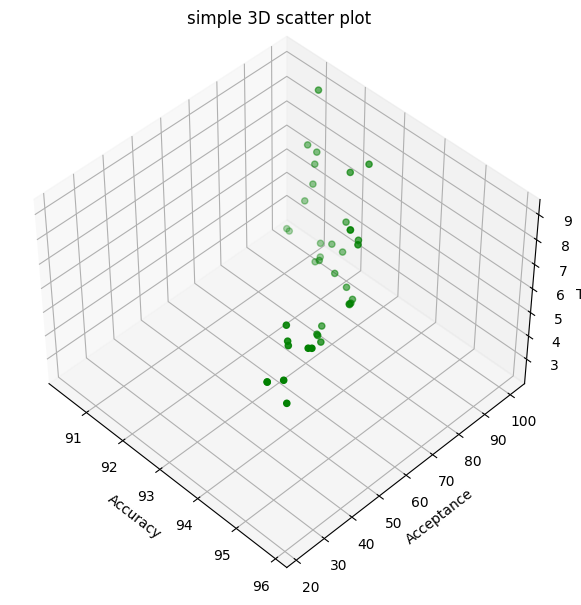